In [1]:
import scipy.stats as stats
import pymc3 as pm
import numpy as np

## Background+Signal model - Bayes-theorem

In [2]:
# Signal model parameters
mean = 50.0
sigma = 5.0
# Bkg model parameters
bkg_low = 0.0
bkg_up = 100.0

data_sig = stats.norm.rvs(loc=mean, scale=sigma, size=500) 
data_bkg = stats.uniform.rvs(loc=bkg_low, scale=bkg_up, size=2000)
data = np.concatenate((data_bkg, data_sig), axis=None)

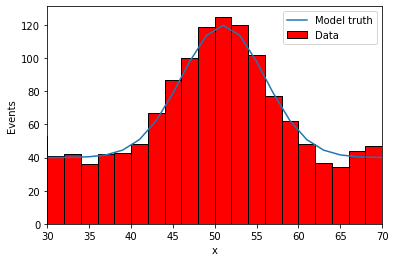

In [31]:
# Plot data as histogram, and model on it
def MyModel(x, A, mu, sigma, bkg):
    y = A*np.exp(-0.5*(x-mu)**2/sigma**2)/(np.sqrt(2*np.pi)*sigma) + bkg 
    return y

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
binwidth = 2
bins = np.arange(20, 80, binwidth)
hist, edges = np.histogram(data, bins)
plt.bar(bins[:-1], hist, width=binwidth, align="edge", ec="k", color='red', label="Data")
plt.plot(bins[:-1]+binwidth/2, MyModel(bins[:-1],1000, mean, sigma, 40), label="Model truth")
ax.set_xlabel("x");ax.set_ylabel("Events")
plt.legend(loc="upper right")
ax.set_xlim(30, 70)
plt.show()

In [46]:
# Assume Poisson Likelihood, and Uniform/Normal priors
with pm.Model() as model_bkgsig:
    # Prior on the mean, Amp, sigma of Signal
    m = pm.Uniform("m", lower=1,upper= 1000)
    Amp = pm.Uniform("A", lower=1, upper = 10000)
    s = pm.Uniform("s", lower=1, upper=100)
    # Prior on the mean background level
    b = pm.Uniform("b", lower=1, upper = 100)
    # Likelihood Poisson
    y = pm.Poisson("y", mu=MyModel(bins[:-1]+binwidth/2,Amp, m, s, b), observed = hist)
    # instantiate sampler (optional)
    step = pm.Metropolis() 
    # Draw posterior samples
    trace = pm.sample(20000, step=step, tune=2000, return_inferencedata=False)  # Explore and Sample the Parameter Space!

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [b]
>Metropolis: [s]
>Metropolis: [A]
>Metropolis: [m]


Sampling 4 chains for 2_000 tune and 20_000 draw iterations (8_000 + 80_000 draws total) took 13 seconds.
The number of effective samples is smaller than 10% for some parameters.


array([[<AxesSubplot:title={'center':'m'}>,
        <AxesSubplot:title={'center':'m'}>],
       [<AxesSubplot:title={'center':'A'}>,
        <AxesSubplot:title={'center':'A'}>],
       [<AxesSubplot:title={'center':'s'}>,
        <AxesSubplot:title={'center':'s'}>],
       [<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>]], dtype=object)

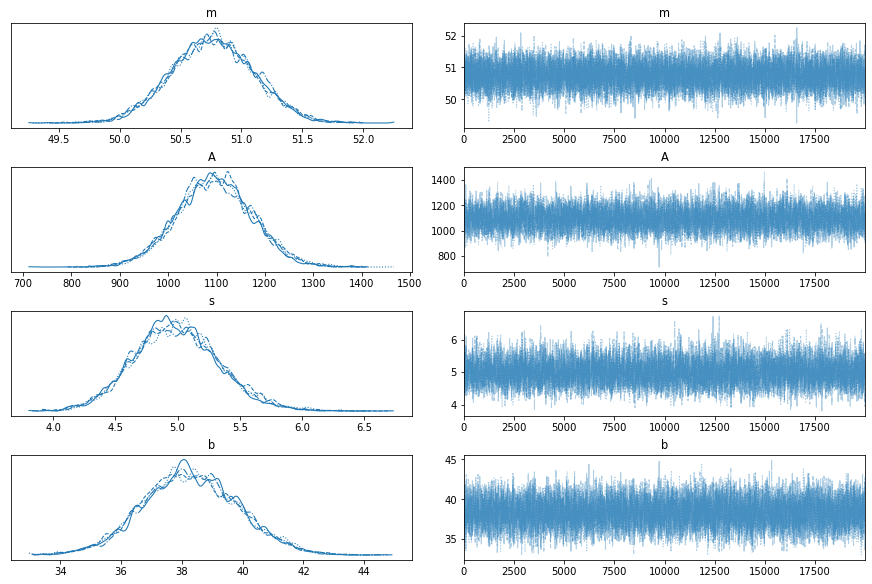

In [45]:
# Exploratory analysis of bayesian models with python
import arviz as az

az.plot_trace(trace, combined=False,divergences="bottom")

In [47]:
az.summary(trace)

/Users/balintradics/opt/anaconda3/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
m,50.755,0.335,50.141,51.392,0.006,0.005,2714.0,2079.0,1.0
A,1095.400,78.236,957.300,1253.366,1.383,0.980,3217.0,4254.0,1.0
s,4.980,0.349,4.326,5.625,0.005,0.004,4199.0,5667.0,1.0
b,38.327,1.588,35.322,41.297,0.023,0.016,4711.0,7436.0,1.0


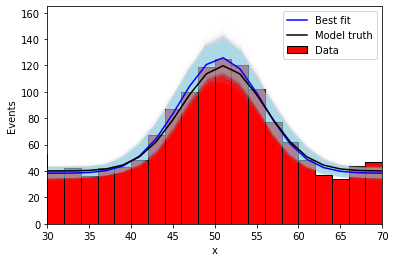

In [37]:
# Visualize fit and uncertainty
# plot the data
fig, ax = plt.subplots(1, 1)
plt.bar(bins[:-1], hist, width=binwidth, align="edge", ec="k", color='red', label="Data")

# Get the mean inferred values
burnin = 100
A_m = trace["A"].mean()
m_m = trace["m"].mean()
s_m = trace["s"].mean()
b_m = trace["b"].mean()

# Plot all draws
draws = range(burnin, len(trace["A"]), 10)
plt.plot(bins[:-1]+binwidth/2, MyModel(bins[:-1, np.newaxis]+binwidth/2,trace["A"][draws], trace["m"][draws], 
                                       trace["s"][draws], trace["b"][draws]), c='lightblue', alpha=0.01)


# Plot the mean regression line
plt.plot(bins[:-1]+binwidth/2, MyModel(bins[:-1]+binwidth/2, A_m, m_m, s_m, b_m), c='blue', label="Best fit")

# Ground truth
plt.plot(bins[:-1]+binwidth/2, MyModel(bins[:-1],1000, mean, sigma, 40), c='black', label="Model truth")

ax.set_xlim(30, 70)
ax.set_xlabel("x");ax.set_ylabel("Events")
plt.legend(loc="upper right")
plt.show()

/Users/balintradics/opt/anaconda3/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<AxesSubplot:title={'center':'m'}>,
       <AxesSubplot:title={'center':'A'}>,
       <AxesSubplot:title={'center':'s'}>,
       <AxesSubplot:title={'center':'b'}>], dtype=object)

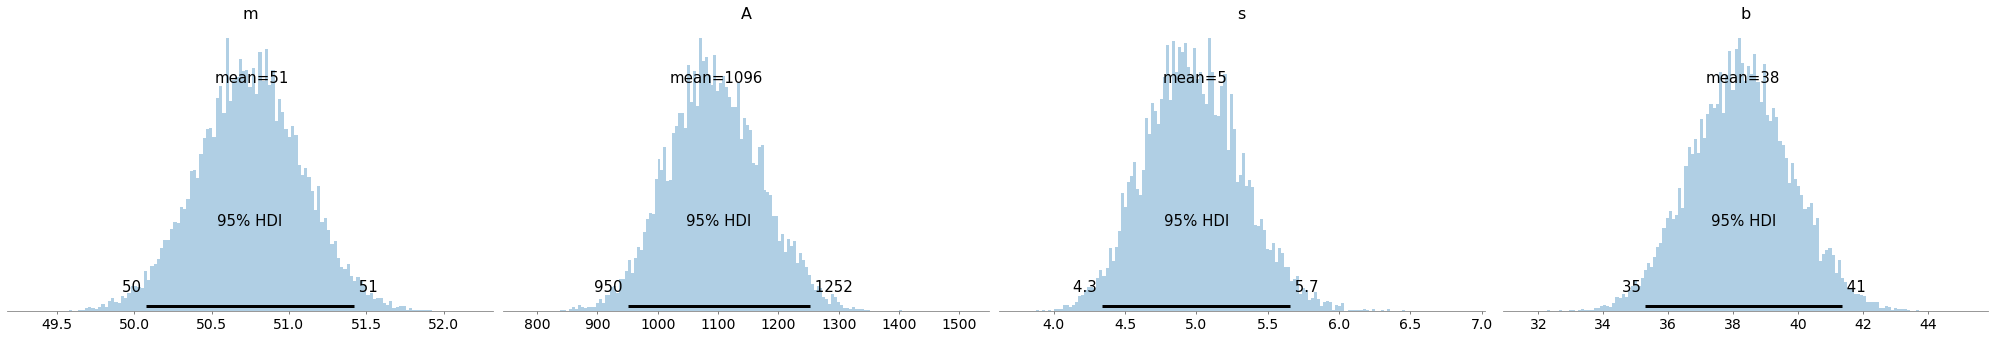

In [38]:
pm.plot_posterior(trace[:][burnin:], kind='hist', hdi_prob=0.95)

/var/folders/24/yt0nmmbs2rg59yttm9w266w80000gn/T/ipykernel_67000/2146015436.py:5: DeprecationWarning: The function `autocorrplot` from PyMC3 is just an alias for `plot_autocorr` from ArviZ. Please switch to `pymc3.plot_autocorr` or `arviz.plot_autocorr`.
  pm.plots.autocorrplot(trace,figsize=(17,5), combined=True);
/Users/balintradics/opt/anaconda3/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


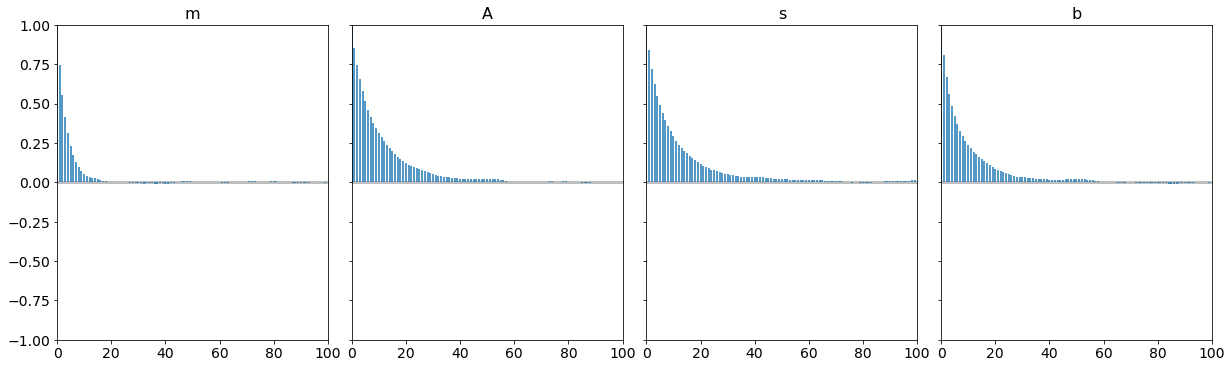

In [39]:
# Plot autocorrelations
#pm.plot_autocorr(trace, combined=True);
thin = 20
#pm.plots.autocorrplot(trace[burnin::thin],figsize=(17,5), combined=True);
pm.plots.autocorrplot(trace,figsize=(17,5), combined=True);

/var/folders/24/yt0nmmbs2rg59yttm9w266w80000gn/T/ipykernel_67000/1937511058.py:1: DeprecationWarning: The function `pairplot` from PyMC3 is just an alias for `plot_pair` from ArviZ. Please switch to `pymc3.plot_pair` or `arviz.plot_pair`.
  pm.pairplot(trace[:][burnin:], kind='kde');
/Users/balintradics/opt/anaconda3/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


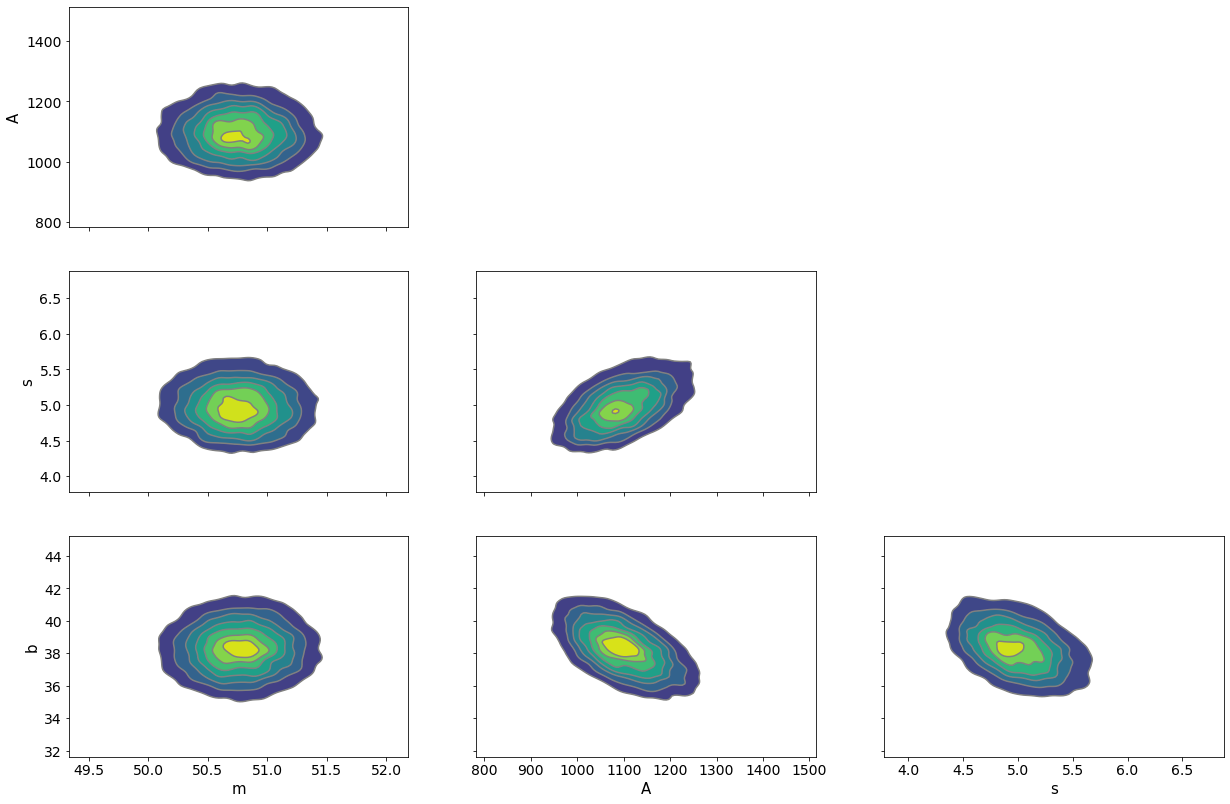

In [40]:
pm.pairplot(trace[:][burnin:], kind='kde');

In [ ]:
import arviz as az
az.plot_pair(trace, var_names=['A', 'm', 's', 'b'], kind='kde')